In [2]:
import polaris as po
import datamol as mo
from splito.simpd import SIMPDSplitter
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data and save
For some reason, retrieving the cached data doesn't work. So saving data to a CSV, the old school way. 

In [3]:
challenge = "antiviral-admet-2025"
datadir = Path('../admet/data')
datadir.mkdir(exist_ok=True, parents=True)
data_fname = datadir.joinpath('train_inc_censored.csv')

if data_fname.exists: 
    data = pd.read_csv(str(data_fname))
else:
    competition = po.load_competition(f"asap-discovery/{challenge}")
    train, test = competition.get_train_test_split()
    data = train.as_dataframe()
    data.to_csv(datadir / 'train_data.csv', index=False)

# Splitting algorithm

## Classify compounds values

The molecules need to be classified as active (good) / inactive (bad).  In the paper they use a cutoff for potency which give a 40/60 split (I think!). I think this is just to ensure we have an approximate fraction of good and bad molecules in the training and test set.  

In general, the ideal drug will generally have: 

1. High solubility -> high KSOL.
3. High CNS penetrance -> High MDR1-MDCKII 
2. Long half life -> low MLM and HLM. 
4. Low lipophilicity -> Low LogD.

So let's rank the compounds, keeping the NaNs present and then take their mean rank after ignoring the NaNs.  Then we'll choose a rank which gives a 60:40 inactive/active split.

If you're doing this on potency - just select a IC50 value which you think is good (20nM is the minimal value from the Target Candidate Profiles). 

In [4]:
# Larger rank is better: 
data['KSOL_rank'] = data['KSOL'].rank(na_option='keep', ascending=True)
data['LogD_rank'] = data['LogD'].rank(na_option='keep', ascending=False)
data['MLM_rank'] = data['MLM'].rank(na_option='keep', ascending=False)
data['HLM_rank'] = data['HLM'].rank(na_option='keep', ascending=False)
data['MDR1-MDCKII_rank'] = data['MDR1-MDCKII'].rank(na_option='keep', ascending=True)
data['mean_rank'] = data.filter(regex='rank', axis=1).apply(lambda x: np.mean(x.values, where=~np.isnan(x.values)), axis=1)

Let's find the rank that gives 40% 'active': 

In [6]:
for c in np.arange(200, 250):
    print(f"{c}: fraction active: {np.mean(data['mean_rank'] > c): 4.1%}")

200: fraction active:  42.9%
201: fraction active:  42.9%
202: fraction active:  42.2%
203: fraction active:  41.7%
204: fraction active:  41.5%
205: fraction active:  41.0%
206: fraction active:  40.8%
207: fraction active:  40.3%
208: fraction active:  40.1%
209: fraction active:  39.2%
210: fraction active:  38.5%
211: fraction active:  38.5%
212: fraction active:  38.2%
213: fraction active:  37.1%
214: fraction active:  36.6%
215: fraction active:  36.2%
216: fraction active:  35.7%
217: fraction active:  35.3%
218: fraction active:  35.0%
219: fraction active:  35.0%
220: fraction active:  33.9%
221: fraction active:  33.2%
222: fraction active:  33.2%
223: fraction active:  32.9%
224: fraction active:  32.7%
225: fraction active:  32.3%
226: fraction active:  31.8%
227: fraction active:  31.8%
228: fraction active:  30.6%
229: fraction active:  29.5%
230: fraction active:  29.3%
231: fraction active:  28.8%
232: fraction active:  27.9%
233: fraction active:  27.4%
234: fraction 

In [8]:
rank_cutoff = 208 
data['is_active'] = data['mean_rank'] > rank_cutoff

Let's have a look at the distribution - we'll put it on a log scale to allow easy comparison

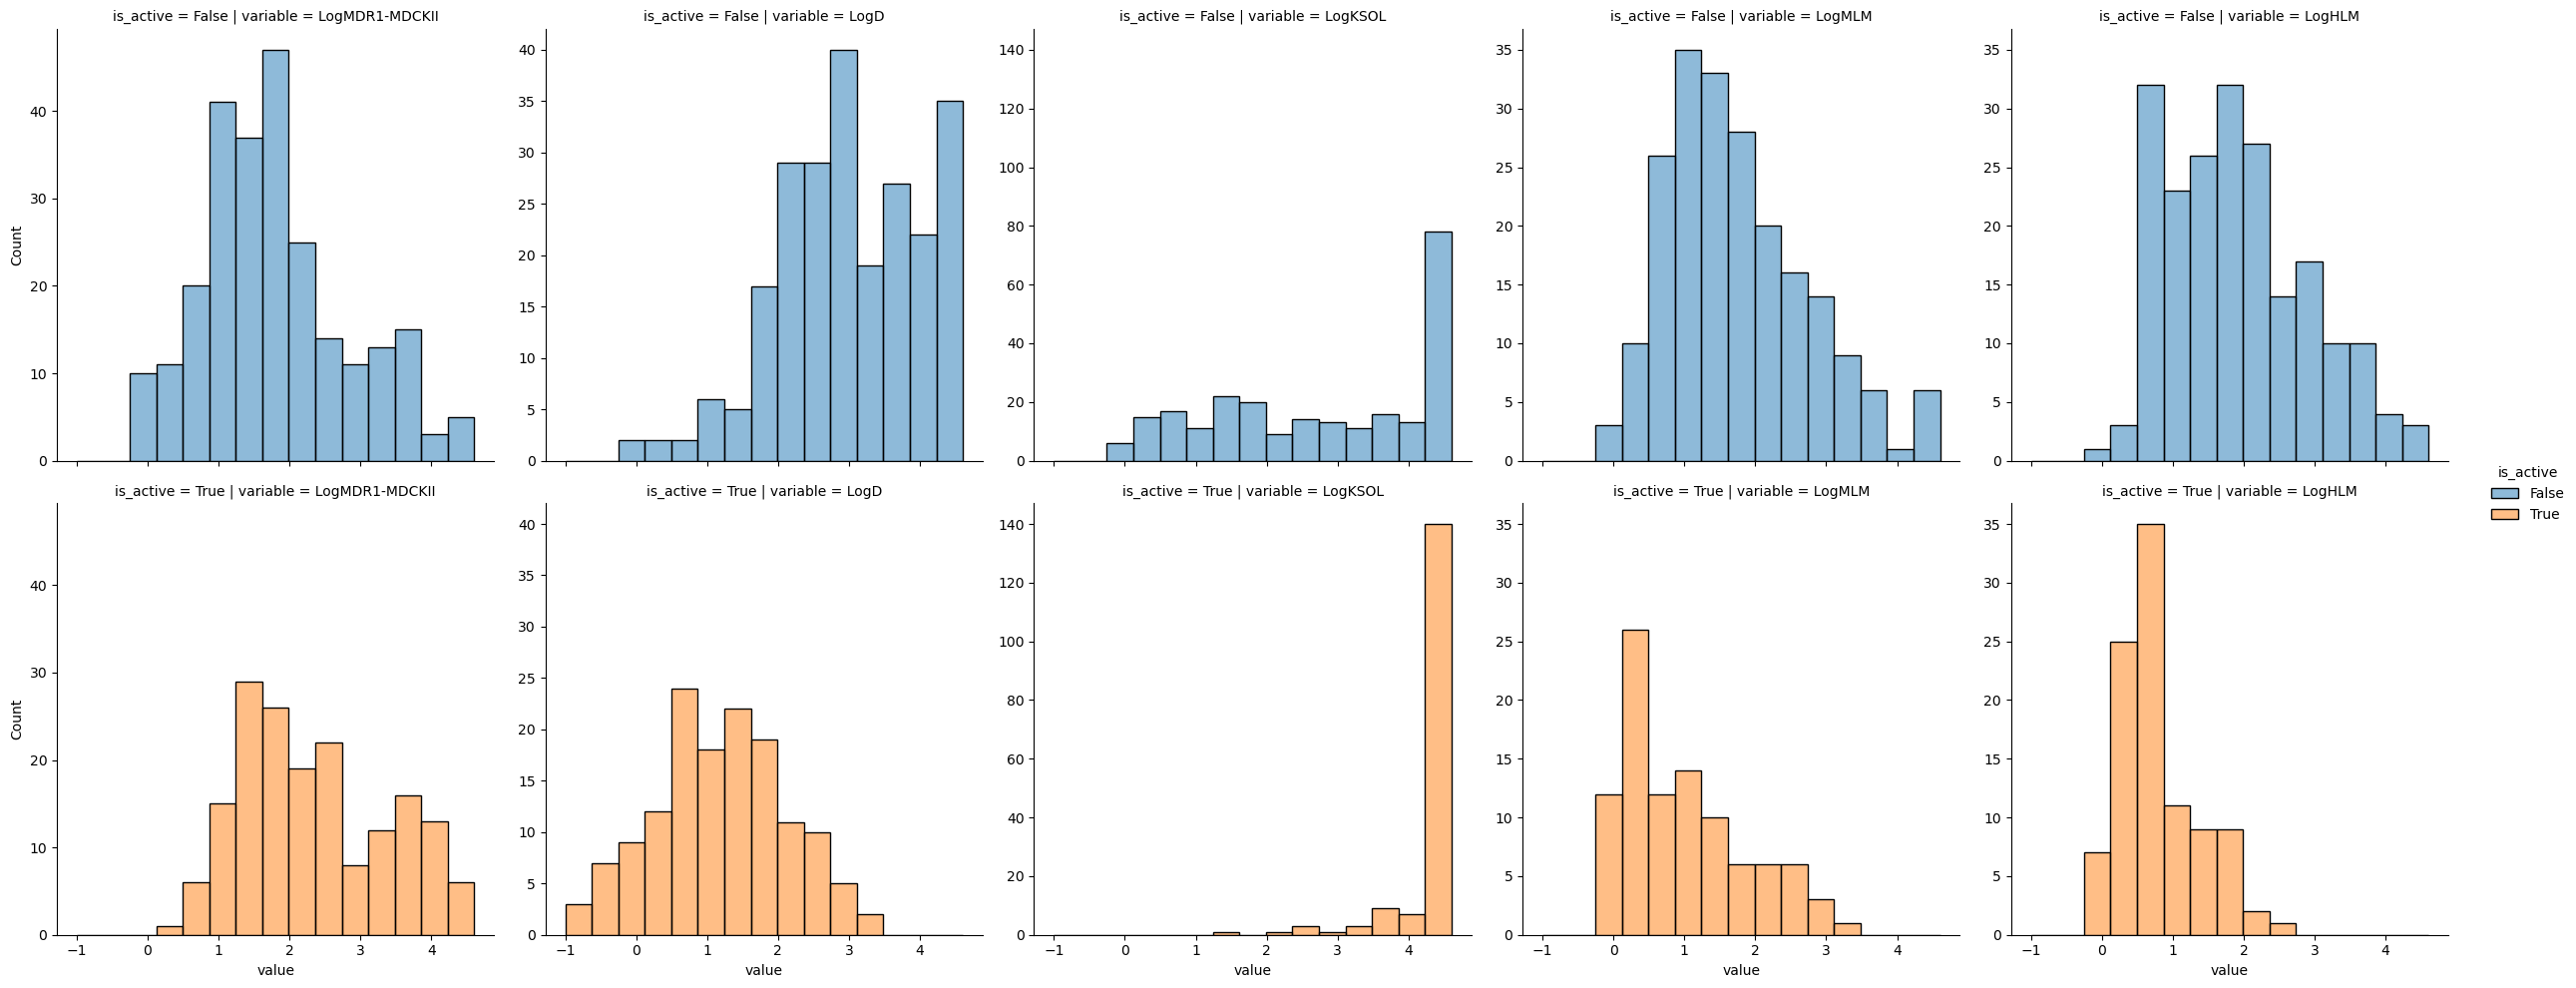

In [9]:

for col in ["MDR1-MDCKII","KSOL", "MLM", "HLM"]:  
    X = data[col]
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    X_scaled = X_std * (100 - 1) + 1

    data[f'Log{col}'] = np.log(X_scaled)

df = data.loc[:, ["LogMDR1-MDCKII", "LogD","LogKSOL", "LogMLM", "LogHLM", "is_active"]].melt(id_vars='is_active')

sns.displot(df, x='value', kind='hist',col='variable', row='is_active', 
            facet_kws=dict(sharey='col', sharex='col'), hue='is_active'
            )

## Define the GA parameters

See https://jcheminf.biomedcentral.com/articles/10.1186/s13321-023-00787-9#Sec2 'Objectives' for more details and also 
https://splito-docs.datamol.io/stable/tutorials/MPO_Splitters.html

In [10]:
args = {}
# GA parameters
args["n_splits"] = 5
args["simpd_descriptors"] = None
args["target_train_frac_active"] = -1
args["target_test_frac_active"] = -1
args["target_delta_test_frac_active"] = None  # [0.11, 0.30] or None
args["target_GF_delta_window"] = (10, 30)
args["target_G_val"] = 70
args["max_population_cluster_entropy"] = 0.9
args["pareto_weight_GF_delta"] = 10
args["pareto_weight_G"] = 5

# compute parameters
args["num_threads"] = 4
args["random_seed"] = 111
args["verbose"] = True
args["verbose_pymoo"] = True
args["progress"] = True
args["progress_leave"] = True

Also need to put the RDKit mol objects in a column 

In [11]:
data['mol'] = [mo.to_mol(x, sanitize=True) for x in data['CXSMILES']]

In [12]:
simpd_splitter = SIMPDSplitter(**args)
result = simpd_splitter.fit(data['mol'].values, data['is_active'].values*1)


2025-02-20 13:47:55.880 | INFO     | splito.simpd.preprocess:preprocess_SIMPD_mols:55 - Compute descriptors and fingerprint values for the molecules.
Preprocess molecules: 100%|██████████| 434/434 [00:00<00:00, 747.49it/s]
2025-02-20 13:47:56.491 | INFO     | splito.simpd.preprocess:preprocess_SIMPD_mols:78 - Compute the distance matrix for the molecules.
2025-02-20 13:47:56.724 | INFO     | splito.simpd.simpd:run_SIMPD:92 - Working with 434 points and picking 86
2025-02-20 13:47:56.737 | INFO     | splito.simpd.simpd:run_SIMPD:108 - Clustering the starting points with a distance threshold of 0.65 and a cluster size threshold of 8.68.
2025-02-20 13:47:56.737 | INFO     | splito.simpd.simpd:run_SIMPD:111 - 9 clusters have been created of size: [76, 94, 53, 41, 39, 44, 41, 24, 22]
2025-02-20 13:47:56.800 | INFO     | splito.simpd.simpd:run_SIMPD:145 - Start the optimization.
Optimization:   1%|          | 1/100 [00:00<00:33,  2.96it/s]

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      136 |     30 |  0.000000E+00 |  0.000000E+00 |             - |             -


Optimization:   2%|▏         | 2/100 [00:01<01:16,  1.28it/s]

     2 |      636 |     44 |  0.000000E+00 |  0.0520000000 |  0.0591174022 |         ideal


Optimization:   3%|▎         | 3/100 [00:02<01:26,  1.12it/s]

     3 |     1136 |     67 |  0.000000E+00 |  0.000000E+00 |  0.0070710742 |         ideal


Optimization:   4%|▍         | 4/100 [00:03<01:29,  1.07it/s]

     4 |     1636 |     95 |  0.000000E+00 |  0.000000E+00 |  0.1809146584 |         nadir


Optimization:   5%|▌         | 5/100 [00:04<01:32,  1.03it/s]

     5 |     2136 |    118 |  0.000000E+00 |  0.000000E+00 |  0.0682444027 |             f


Optimization:   6%|▌         | 6/100 [00:05<01:31,  1.02it/s]

     6 |     2636 |    141 |  0.000000E+00 |  0.000000E+00 |  0.0500416335 |         nadir


Optimization:   7%|▋         | 7/100 [00:06<01:30,  1.02it/s]

     7 |     3136 |    179 |  0.000000E+00 |  0.000000E+00 |  0.0029031790 |         ideal


Optimization:   8%|▊         | 8/100 [00:07<01:29,  1.02it/s]

     8 |     3636 |    219 |  0.000000E+00 |  0.000000E+00 |  0.0621605311 |         nadir


Optimization:   9%|▉         | 9/100 [00:08<01:28,  1.02it/s]

     9 |     4136 |    212 |  0.000000E+00 |  0.000000E+00 |  0.1250000000 |         nadir


Optimization:  10%|█         | 10/100 [00:09<01:28,  1.02it/s]

    10 |     4636 |    238 |  0.000000E+00 |  0.000000E+00 |  0.0409065782 |         nadir


Optimization:  11%|█         | 11/100 [00:10<01:27,  1.02it/s]

    11 |     5136 |    265 |  0.000000E+00 |  0.000000E+00 |  0.0267318422 |             f


Optimization:  12%|█▏        | 12/100 [00:11<01:27,  1.01it/s]

    12 |     5636 |    278 |  0.000000E+00 |  0.000000E+00 |  0.0228965741 |             f


Optimization:  13%|█▎        | 13/100 [00:12<01:26,  1.00it/s]

    13 |     6136 |    311 |  0.000000E+00 |  0.000000E+00 |  0.0205844802 |             f


Optimization:  14%|█▍        | 14/100 [00:13<01:26,  1.01s/it]

    14 |     6636 |    326 |  0.000000E+00 |  0.000000E+00 |  0.0665343045 |         nadir


Optimization:  15%|█▌        | 15/100 [00:14<01:26,  1.02s/it]

    15 |     7136 |    319 |  0.000000E+00 |  0.000000E+00 |  0.0205309878 |             f


Optimization:  16%|█▌        | 16/100 [00:15<01:24,  1.01s/it]

    16 |     7636 |    331 |  0.000000E+00 |  0.000000E+00 |  0.0180203261 |             f


Optimization:  17%|█▋        | 17/100 [00:16<01:23,  1.00s/it]

    17 |     8136 |    350 |  0.000000E+00 |  0.000000E+00 |  0.3841059603 |         nadir


Optimization:  18%|█▊        | 18/100 [00:17<01:21,  1.00it/s]

    18 |     8636 |    341 |  0.000000E+00 |  0.000000E+00 |  0.0158445831 |             f


Optimization:  19%|█▉        | 19/100 [00:18<01:21,  1.00s/it]

    19 |     9136 |    354 |  0.000000E+00 |  0.000000E+00 |  0.1366470384 |         nadir


Optimization:  20%|██        | 20/100 [00:19<01:20,  1.01s/it]

    20 |     9636 |    377 |  0.000000E+00 |  0.000000E+00 |  0.0140336777 |             f


Optimization:  21%|██        | 21/100 [00:20<01:19,  1.00s/it]

    21 |    10136 |    376 |  0.000000E+00 |  0.000000E+00 |  0.0146621915 |             f


Optimization:  22%|██▏       | 22/100 [00:21<01:18,  1.00s/it]

    22 |    10636 |    375 |  0.000000E+00 |  0.000000E+00 |  0.0140601709 |             f


Optimization:  23%|██▎       | 23/100 [00:22<01:17,  1.00s/it]

    23 |    11136 |    376 |  0.000000E+00 |  0.000000E+00 |  0.0102857734 |             f


Optimization:  24%|██▍       | 24/100 [00:23<01:16,  1.00s/it]

    24 |    11636 |    399 |  0.000000E+00 |  0.000000E+00 |  0.0134673244 |             f


Optimization:  25%|██▌       | 25/100 [00:24<01:15,  1.00s/it]

    25 |    12136 |    417 |  0.000000E+00 |  0.000000E+00 |  0.0112679839 |             f


Optimization:  26%|██▌       | 26/100 [00:25<01:13,  1.00it/s]

    26 |    12636 |    418 |  0.000000E+00 |  0.000000E+00 |  0.1582113495 |         nadir


Optimization:  27%|██▋       | 27/100 [00:26<01:13,  1.01s/it]

    27 |    13136 |    430 |  0.000000E+00 |  0.000000E+00 |  0.0128349130 |             f


Optimization:  28%|██▊       | 28/100 [00:27<01:12,  1.00s/it]

    28 |    13636 |    442 |  0.000000E+00 |  0.000000E+00 |  0.0138500068 |             f


Optimization:  29%|██▉       | 29/100 [00:28<01:10,  1.00it/s]

    29 |    14136 |    468 |  0.000000E+00 |  0.000000E+00 |  0.0098374932 |             f


Optimization:  30%|███       | 30/100 [00:29<01:09,  1.00it/s]

    30 |    14636 |    488 |  0.000000E+00 |  0.000000E+00 |  0.3480590772 |         nadir


Optimization:  31%|███       | 31/100 [00:30<01:08,  1.00it/s]

    31 |    15136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.1925465839 |         nadir


Optimization:  32%|███▏      | 32/100 [00:31<01:07,  1.00it/s]

    32 |    15636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0142976705 |             f


Optimization:  33%|███▎      | 33/100 [00:32<01:06,  1.00it/s]

    33 |    16136 |    438 |  0.000000E+00 |  0.000000E+00 |  0.0112562101 |             f


Optimization:  34%|███▍      | 34/100 [00:33<01:05,  1.01it/s]

    34 |    16636 |    454 |  0.000000E+00 |  0.000000E+00 |  0.0083828753 |             f


Optimization:  35%|███▌      | 35/100 [00:34<01:04,  1.01it/s]

    35 |    17136 |    422 |  0.000000E+00 |  0.000000E+00 |  0.0095450049 |             f


Optimization:  36%|███▌      | 36/100 [00:35<01:03,  1.01it/s]

    36 |    17636 |    436 |  0.000000E+00 |  0.000000E+00 |  0.0097361184 |             f


Optimization:  37%|███▋      | 37/100 [00:36<01:02,  1.01it/s]

    37 |    18136 |    438 |  0.000000E+00 |  0.000000E+00 |  0.0050788479 |             f


Optimization:  38%|███▊      | 38/100 [00:37<01:02,  1.01s/it]

    38 |    18636 |    455 |  0.000000E+00 |  0.000000E+00 |  0.0062600923 |             f


Optimization:  39%|███▉      | 39/100 [00:38<01:01,  1.01s/it]

    39 |    19136 |    467 |  0.000000E+00 |  0.000000E+00 |  0.0074995747 |             f


Optimization:  40%|████      | 40/100 [00:39<01:01,  1.02s/it]

    40 |    19636 |    488 |  0.000000E+00 |  0.000000E+00 |  0.0092031865 |             f


Optimization:  41%|████      | 41/100 [00:40<01:01,  1.04s/it]

    41 |    20136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.1033666335 |         nadir


Optimization:  42%|████▏     | 42/100 [00:41<01:00,  1.05s/it]

    42 |    20636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0077530035 |             f


Optimization:  43%|████▎     | 43/100 [00:42<00:58,  1.03s/it]

    43 |    21136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.1776384535 |         nadir


Optimization:  44%|████▍     | 44/100 [00:43<00:57,  1.03s/it]

    44 |    21636 |    480 |  0.000000E+00 |  0.000000E+00 |  0.0084412379 |             f


Optimization:  45%|████▌     | 45/100 [00:44<00:57,  1.04s/it]

    45 |    22136 |    499 |  0.000000E+00 |  0.000000E+00 |  0.0058497044 |             f


Optimization:  46%|████▌     | 46/100 [00:45<00:56,  1.04s/it]

    46 |    22636 |    474 |  0.000000E+00 |  0.000000E+00 |  0.0065630596 |             f


Optimization:  47%|████▋     | 47/100 [00:46<00:55,  1.05s/it]

    47 |    23136 |    494 |  0.000000E+00 |  0.000000E+00 |  0.0063206519 |             f


Optimization:  48%|████▊     | 48/100 [00:47<00:53,  1.03s/it]

    48 |    23636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0079654122 |             f


Optimization:  49%|████▉     | 49/100 [00:48<00:52,  1.03s/it]

    49 |    24136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0082935711 |             f


Optimization:  50%|█████     | 50/100 [00:49<00:51,  1.02s/it]

    50 |    24636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0082500707 |             f


Optimization:  51%|█████     | 51/100 [00:50<00:50,  1.04s/it]

    51 |    25136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0063180972 |             f


Optimization:  52%|█████▏    | 52/100 [00:51<00:49,  1.04s/it]

    52 |    25636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0053154870 |             f


Optimization:  53%|█████▎    | 53/100 [00:53<00:48,  1.03s/it]

    53 |    26136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0070916219 |             f


Optimization:  54%|█████▍    | 54/100 [00:54<00:47,  1.02s/it]

    54 |    26636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.7440164121 |         nadir


Optimization:  55%|█████▌    | 55/100 [00:54<00:45,  1.01s/it]

    55 |    27136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0075998213 |             f


Optimization:  56%|█████▌    | 56/100 [00:55<00:44,  1.00s/it]

    56 |    27636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0094744401 |             f


Optimization:  57%|█████▋    | 57/100 [00:56<00:42,  1.01it/s]

    57 |    28136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0057057293 |             f


Optimization:  58%|█████▊    | 58/100 [00:57<00:41,  1.01it/s]

    58 |    28636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0062848692 |             f


Optimization:  59%|█████▉    | 59/100 [00:58<00:40,  1.02it/s]

    59 |    29136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0098135542 |             f


Optimization:  60%|██████    | 60/100 [00:59<00:39,  1.02it/s]

    60 |    29636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0055484707 |             f


Optimization:  61%|██████    | 61/100 [01:00<00:38,  1.03it/s]

    61 |    30136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0103738932 |             f


Optimization:  62%|██████▏   | 62/100 [01:01<00:37,  1.03it/s]

    62 |    30636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0080766548 |             f


Optimization:  63%|██████▎   | 63/100 [01:02<00:36,  1.02it/s]

    63 |    31136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0083032021 |             f


Optimization:  64%|██████▍   | 64/100 [01:03<00:35,  1.02it/s]

    64 |    31636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0081805630 |             f


Optimization:  65%|██████▌   | 65/100 [01:04<00:34,  1.02it/s]

    65 |    32136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0075399481 |             f


Optimization:  66%|██████▌   | 66/100 [01:05<00:33,  1.02it/s]

    66 |    32636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0090394474 |             f


Optimization:  67%|██████▋   | 67/100 [01:06<00:32,  1.02it/s]

    67 |    33136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0124588437 |             f


Optimization:  68%|██████▊   | 68/100 [01:07<00:31,  1.01it/s]

    68 |    33636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0088795257 |             f


Optimization:  69%|██████▉   | 69/100 [01:08<00:30,  1.01it/s]

    69 |    34136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0079089387 |             f


Optimization:  70%|███████   | 70/100 [01:09<00:29,  1.02it/s]

    70 |    34636 |    495 |  0.000000E+00 |  0.000000E+00 |  0.0106446005 |             f


Optimization:  71%|███████   | 71/100 [01:10<00:28,  1.02it/s]

    71 |    35136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0095628865 |             f


Optimization:  72%|███████▏  | 72/100 [01:11<00:27,  1.03it/s]

    72 |    35636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0877025739 |         nadir


Optimization:  73%|███████▎  | 73/100 [01:12<00:26,  1.03it/s]

    73 |    36136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0071386772 |             f


Optimization:  74%|███████▍  | 74/100 [01:13<00:25,  1.03it/s]

    74 |    36636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0067313046 |             f


Optimization:  75%|███████▌  | 75/100 [01:14<00:24,  1.03it/s]

    75 |    37136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0085692919 |             f


Optimization:  76%|███████▌  | 76/100 [01:15<00:23,  1.03it/s]

    76 |    37636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0104472283 |             f


Optimization:  77%|███████▋  | 77/100 [01:16<00:22,  1.02it/s]

    77 |    38136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0074292903 |             f


Optimization:  78%|███████▊  | 78/100 [01:17<00:21,  1.03it/s]

    78 |    38636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0073276891 |             f


Optimization:  79%|███████▉  | 79/100 [01:18<00:20,  1.02it/s]

    79 |    39136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0073546291 |             f


Optimization:  80%|████████  | 80/100 [01:19<00:19,  1.03it/s]

    80 |    39636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0085187557 |             f


Optimization:  81%|████████  | 81/100 [01:20<00:18,  1.01it/s]

    81 |    40136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0109065413 |             f


Optimization:  82%|████████▏ | 82/100 [01:21<00:17,  1.01it/s]

    82 |    40636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0080490016 |             f


Optimization:  83%|████████▎ | 83/100 [01:22<00:16,  1.02it/s]

    83 |    41136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0082826201 |             f


Optimization:  84%|████████▍ | 84/100 [01:23<00:15,  1.03it/s]

    84 |    41636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0093766086 |             f


Optimization:  85%|████████▌ | 85/100 [01:24<00:14,  1.03it/s]

    85 |    42136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0095903283 |             f


Optimization:  86%|████████▌ | 86/100 [01:25<00:13,  1.03it/s]

    86 |    42636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0091791983 |             f


Optimization:  87%|████████▋ | 87/100 [01:26<00:12,  1.03it/s]

    87 |    43136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0075874500 |             f


Optimization:  88%|████████▊ | 88/100 [01:27<00:11,  1.03it/s]

    88 |    43636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0101034565 |             f


Optimization:  89%|████████▉ | 89/100 [01:28<00:10,  1.04it/s]

    89 |    44136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0119859184 |             f


Optimization:  90%|█████████ | 90/100 [01:29<00:09,  1.03it/s]

    90 |    44636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0077592432 |             f


Optimization:  91%|█████████ | 91/100 [01:30<00:08,  1.03it/s]

    91 |    45136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0092548103 |             f


Optimization:  92%|█████████▏| 92/100 [01:31<00:07,  1.03it/s]

    92 |    45636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0102160336 |             f


Optimization:  93%|█████████▎| 93/100 [01:32<00:06,  1.03it/s]

    93 |    46136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0904365904 |         nadir


Optimization:  94%|█████████▍| 94/100 [01:33<00:05,  1.02it/s]

    94 |    46636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0097755486 |             f


Optimization:  95%|█████████▌| 95/100 [01:34<00:04,  1.02it/s]

    95 |    47136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0141534964 |             f


Optimization:  96%|█████████▌| 96/100 [01:35<00:03,  1.02it/s]

    96 |    47636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0115898441 |             f


Optimization:  97%|█████████▋| 97/100 [01:35<00:02,  1.03it/s]

    97 |    48136 |    451 |  0.000000E+00 |  0.000000E+00 |  0.0108939406 |             f


Optimization:  98%|█████████▊| 98/100 [01:36<00:01,  1.03it/s]

    98 |    48636 |    479 |  0.000000E+00 |  0.000000E+00 |  0.0084586675 |             f


Optimization:  99%|█████████▉| 99/100 [01:37<00:00,  1.03it/s]

    99 |    49136 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0091327997 |             f


Optimization: 100%|██████████| 100/100 [01:38<00:00,  1.01it/s]
2025-02-20 13:49:35.717 | INFO     | splito.simpd.simpd:run_SIMPD:173 - Found 500 solutions
2025-02-20 13:49:35.718 | INFO     | splito.simpd.simpd:run_SIMPD:176 - Scoring the solutions.
2025-02-20 13:49:35.721 | INFO     | splito.simpd.simpd:run_SIMPD:195 - Objective values for the best solution: [0.52226259 0.4        0.63       0.6977561  0.01768299 0.
 0.        ]


   100 |    49636 |    500 |  0.000000E+00 |  0.000000E+00 |  0.0072830776 |             f


The result object contains all results, ordered by their pareto scores. Each result is a train_idx, and test_idx. 

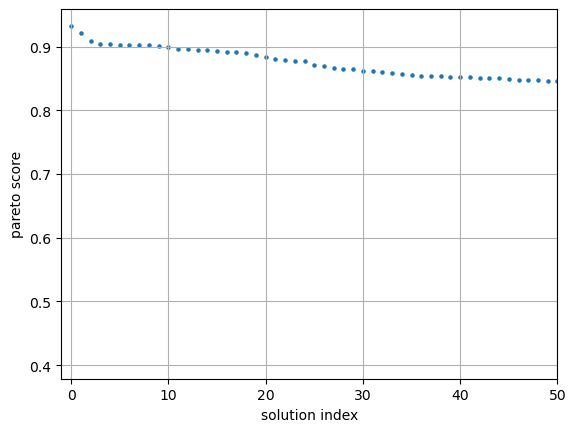

In [13]:
plt.scatter(np.arange(result.pareto_scores.shape[0]), result.pareto_scores, ls='-', s=5)
plt.xlabel('solution index')
plt.ylabel('pareto score')
plt.xlim(-1, 50)
plt.grid()

Ideally I'd like multiple solutions to get statistics but that is for another day. 

In [15]:
np.save('../admet/data/train_inc_censored_idx.npy', result.train_indices[0])
np.save('../admet/data/test_inc_censored_idx.npy', result.test_indices[0])